In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
train_set = torchvision.datasets.FashionMNIST(root = ".", train=True,
download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train=False,
download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# fixing the seed to reproduce outcomes
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

Label is: 3
Dimension of input data: torch.Size([32, 1, 28, 28])
Dimension of labels: torch.Size([32])


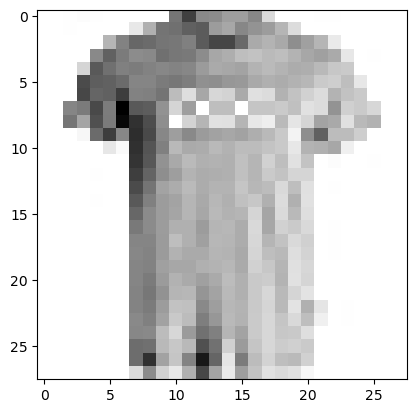

In [2]:
input_data, label = next(iter(train_loader))
plt.imshow(input_data[3,:,:,:].numpy().reshape(28,28), cmap="gray_r");
print("Label is: {}".format(label[0]))
print("Dimension of input data: {}".format(input_data.size()))
print("Dimension of labels: {}".format(label.size()))

In [3]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()
    
    # Parameters used to input in first convolution layer are specified as follows
    # 1: number of input channels (1 for the images of the FashionMNIST dataset)
    # 2: number of output channels = 32
    # 3: kernel dimensionality (5 as the kernel is 5x5)
    # 4: stride dimensionality (1 as the stride is 1x1)
    
    # Using Relu as activation function as specified in the task
    
    # Parameters to input to nn.MaxPool2d as specified in the task
    # 1: kernel dimensionality (2 as the kernel is 5x5)
    # 2: stride dimensionality (2 as the stride is 2x2)
    
    # Parameters used to input in second convolution layer are specified as follows
    # 1: the first input parameter specifies the number of output channels from the previous layer (i.e. 32)
    # 2: number of output channels = 64
    # 3: kernel dimensionality (5 as both the kernel is 5x5)
    # 4: stride dimensionality (1 as both the stride is 1x1)    
    
    # Using the Sequential container to run layers sequentially
    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.ReLU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.ReLU(), nn.MaxPool2d(2, stride = 2))
    
    
    # Parameters to input to First fully-connected layer
    # 1: last output size of max pooling layer(i.e 1024)
    # 2: output dimension = 1024
    

    # Parameters to input to Second fully-connected layer
    # 1: output size of First fully-connected(i.e 1024)
    # 2: output dimension = 256
    
    # Parameters to output layer 
    # 1:output size of First fully-connected(256)
    # 2: output dimension = 10
 
    
    # using the Sequential container to run layers sequentially
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024,256), nn.ReLU(), nn.Linear(256, 10))
 
   
  def forward(self, x):
    
    # pass input via the CNN layers
    x = self.cnn_model(x)
    # we reshape the tensor
    # we keep the first dimension (batch_size)
    # we let Pytorch compute the second dimension 
    # (-1 means compute this dimension given the others)
    x =x.view(x.size(0), -1)
    # pass input via the fully-connected layers
    x = self.fc_model(x)
    
    return x

In [4]:
def evaluation(dataloader):
  total, correct = 0,0
  # turn on evaluate mode, this de-activates certain modes such as dropout

  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    # we take the index of the class that received the highest value  
    # we take outputs.data so that no backpropagation is performed for these outputs
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    # .item() takes Python float values from the tensor
    correct += (pred == labels).sum().item()
  return 100 * correct / total

In [5]:
def weights_init(m):
    # initialise both linear and convolutional layers
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)

In [6]:
device = torch.device("cuda:0")

alpha = 0.1

net = MyCNN().to(device)
# initialise weights
net.apply(weights_init)

# Note: CrossEntropy loss is usually used for classification tasks
# check slide 25 of Lecture 8.2
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# SGD optimiser, learning rate is specified by alpha
opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []
# loop over epochs
for epoch in range(max_epochs):
  # we will compute sum of batch losses per epoch
  loss_epoch = 0
  # loop over batches
  for i, data in enumerate(tqdm(train_loader), 0):
    # to ensure the training mode is "turned on"
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the gradients
    opt.zero_grad()
    outputs = net(inputs)
    # compute the loss
    loss = loss_fn(outputs, labels)
    # calculate the gradients
    loss.backward()
    # update the parameters using the gradients and optimizer algorithm 
    opt.step()
    # we sum the loss over batches
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))

100%|██████████| 1875/1875 [00:11<00:00, 158.95it/s]


Epoch 1: loss: 1025.6925526186824, train accuracy: 87.34833333333333, valid accuracy:86.14


100%|██████████| 1875/1875 [00:08<00:00, 210.22it/s]


Epoch 2: loss: 619.6894595362246, train accuracy: 89.855, valid accuracy:88.38


100%|██████████| 1875/1875 [00:08<00:00, 212.40it/s]


Epoch 3: loss: 528.0960752796382, train accuracy: 90.85, valid accuracy:89.07


100%|██████████| 1875/1875 [00:08<00:00, 210.28it/s]


Epoch 4: loss: 472.22957417182624, train accuracy: 91.70333333333333, valid accuracy:89.62


100%|██████████| 1875/1875 [00:08<00:00, 215.03it/s]


Epoch 5: loss: 425.2454704558477, train accuracy: 92.61333333333333, valid accuracy:90.47


100%|██████████| 1875/1875 [00:08<00:00, 210.67it/s]


Epoch 6: loss: 382.4407505784184, train accuracy: 93.71166666666667, valid accuracy:90.64


100%|██████████| 1875/1875 [00:09<00:00, 200.69it/s]


Epoch 7: loss: 344.5221441644244, train accuracy: 93.42333333333333, valid accuracy:89.62


100%|██████████| 1875/1875 [00:09<00:00, 203.84it/s]


Epoch 8: loss: 312.4847698388621, train accuracy: 94.65666666666667, valid accuracy:90.62


100%|██████████| 1875/1875 [00:09<00:00, 203.59it/s]


Epoch 9: loss: 281.2691122889519, train accuracy: 95.61666666666666, valid accuracy:91.03


100%|██████████| 1875/1875 [00:08<00:00, 208.75it/s]


Epoch 10: loss: 249.34835630934685, train accuracy: 95.865, valid accuracy:90.83


100%|██████████| 1875/1875 [00:08<00:00, 212.56it/s]


Epoch 11: loss: 226.96841353550553, train accuracy: 95.93166666666667, valid accuracy:90.59


100%|██████████| 1875/1875 [00:08<00:00, 223.60it/s]


Epoch 12: loss: 203.44685385306366, train accuracy: 96.83166666666666, valid accuracy:91.11


100%|██████████| 1875/1875 [00:08<00:00, 226.29it/s]


Epoch 13: loss: 183.17945109400898, train accuracy: 96.98833333333333, valid accuracy:90.99


100%|██████████| 1875/1875 [00:08<00:00, 222.47it/s]


Epoch 14: loss: 161.04493973241188, train accuracy: 96.97, valid accuracy:90.31


100%|██████████| 1875/1875 [00:08<00:00, 216.26it/s]


Epoch 15: loss: 150.0737136726966, train accuracy: 97.51666666666667, valid accuracy:91.0


100%|██████████| 1875/1875 [00:08<00:00, 220.82it/s]


Epoch 16: loss: 133.21120384868118, train accuracy: 97.715, valid accuracy:90.74


100%|██████████| 1875/1875 [00:09<00:00, 205.97it/s]


Epoch 17: loss: 125.66378437401727, train accuracy: 98.41, valid accuracy:91.27


100%|██████████| 1875/1875 [00:08<00:00, 219.57it/s]


Epoch 18: loss: 117.6397516191355, train accuracy: 98.04833333333333, valid accuracy:91.12


100%|██████████| 1875/1875 [00:08<00:00, 224.69it/s]


Epoch 19: loss: 113.87053819021821, train accuracy: 98.26, valid accuracy:90.75


100%|██████████| 1875/1875 [00:08<00:00, 222.08it/s]


Epoch 20: loss: 96.31247779359546, train accuracy: 97.76166666666667, valid accuracy:90.49


100%|██████████| 1875/1875 [00:08<00:00, 225.88it/s]


Epoch 21: loss: 95.88722333618352, train accuracy: 98.53833333333333, valid accuracy:90.72


100%|██████████| 1875/1875 [00:08<00:00, 224.34it/s]


Epoch 22: loss: 89.19845932254248, train accuracy: 98.58833333333334, valid accuracy:91.16


100%|██████████| 1875/1875 [00:08<00:00, 223.69it/s]


Epoch 23: loss: 86.69084064630806, train accuracy: 98.54, valid accuracy:90.94


100%|██████████| 1875/1875 [00:08<00:00, 225.81it/s]


Epoch 24: loss: 69.2925554135727, train accuracy: 99.25166666666667, valid accuracy:91.1


100%|██████████| 1875/1875 [00:09<00:00, 207.91it/s]


Epoch 25: loss: 66.32904085754308, train accuracy: 98.17, valid accuracy:90.26


100%|██████████| 1875/1875 [00:08<00:00, 211.59it/s]


Epoch 26: loss: 72.7324161692759, train accuracy: 98.57833333333333, valid accuracy:90.93


100%|██████████| 1875/1875 [00:08<00:00, 213.04it/s]


Epoch 27: loss: 61.33361843065177, train accuracy: 99.125, valid accuracy:90.73


100%|██████████| 1875/1875 [00:08<00:00, 216.41it/s]


Epoch 28: loss: 58.135852959652766, train accuracy: 99.13, valid accuracy:90.9


100%|██████████| 1875/1875 [00:08<00:00, 217.12it/s]


Epoch 29: loss: 51.64867698322905, train accuracy: 99.445, valid accuracy:91.44


100%|██████████| 1875/1875 [00:08<00:00, 212.73it/s]


Epoch 30: loss: 43.546225580092596, train accuracy: 99.55, valid accuracy:91.27


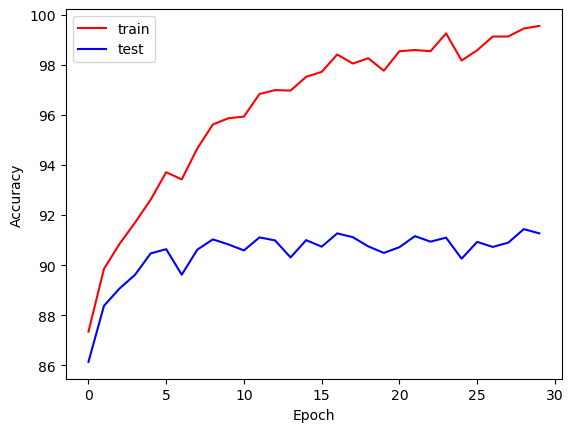

In [7]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))

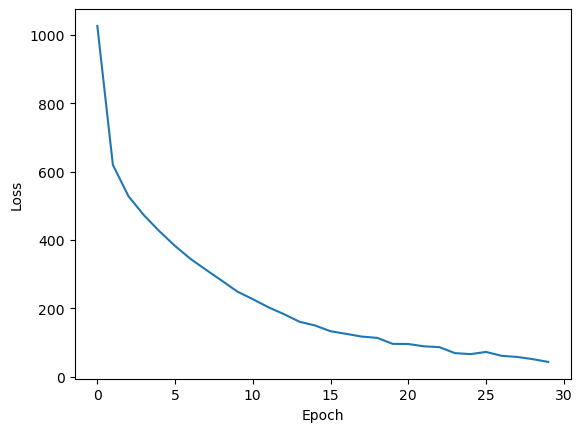

In [8]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

### Using Tanh Activation function 

100%|██████████| 1875/1875 [00:09<00:00, 200.99it/s]


Epoch 1: loss: 871.8960928022861, train accuracy: 86.875, valid accuracy:85.71


100%|██████████| 1875/1875 [00:09<00:00, 203.91it/s]


Epoch 2: loss: 597.8856916800141, train accuracy: 90.07, valid accuracy:88.25


100%|██████████| 1875/1875 [00:09<00:00, 192.74it/s]


Epoch 3: loss: 502.9437311189249, train accuracy: 91.78333333333333, valid accuracy:89.51


100%|██████████| 1875/1875 [00:09<00:00, 200.39it/s]


Epoch 4: loss: 436.6968989567831, train accuracy: 92.86833333333334, valid accuracy:89.83


100%|██████████| 1875/1875 [00:08<00:00, 209.78it/s]


Epoch 5: loss: 384.24215891212225, train accuracy: 93.94, valid accuracy:90.61


100%|██████████| 1875/1875 [00:09<00:00, 208.18it/s]


Epoch 6: loss: 335.69540074374527, train accuracy: 94.28, valid accuracy:90.09


100%|██████████| 1875/1875 [00:09<00:00, 204.31it/s]


Epoch 7: loss: 294.15069261193275, train accuracy: 95.12833333333333, valid accuracy:90.46


100%|██████████| 1875/1875 [00:09<00:00, 200.00it/s]


Epoch 8: loss: 254.7905839048326, train accuracy: 95.32833333333333, valid accuracy:89.95


100%|██████████| 1875/1875 [00:09<00:00, 202.77it/s]


Epoch 9: loss: 216.18389040743932, train accuracy: 96.25833333333334, valid accuracy:90.05


100%|██████████| 1875/1875 [00:09<00:00, 206.12it/s]


Epoch 10: loss: 183.18711209692992, train accuracy: 96.99, valid accuracy:90.17


100%|██████████| 1875/1875 [00:09<00:00, 204.14it/s]


Epoch 11: loss: 154.41425151447766, train accuracy: 97.72333333333333, valid accuracy:90.86


100%|██████████| 1875/1875 [00:09<00:00, 207.76it/s]


Epoch 12: loss: 127.71152751025511, train accuracy: 97.99, valid accuracy:90.86


100%|██████████| 1875/1875 [00:09<00:00, 204.80it/s]


Epoch 13: loss: 106.63877134775976, train accuracy: 98.33166666666666, valid accuracy:90.76


100%|██████████| 1875/1875 [00:09<00:00, 207.18it/s]


Epoch 14: loss: 83.2853021510382, train accuracy: 99.02666666666667, valid accuracy:91.01


100%|██████████| 1875/1875 [00:09<00:00, 196.23it/s]


Epoch 15: loss: 60.89142787599121, train accuracy: 99.22333333333333, valid accuracy:90.74


100%|██████████| 1875/1875 [00:09<00:00, 202.55it/s]


Epoch 16: loss: 44.058272927046346, train accuracy: 99.43333333333334, valid accuracy:91.14


100%|██████████| 1875/1875 [00:09<00:00, 202.03it/s]


Epoch 17: loss: 32.31264678633306, train accuracy: 99.70833333333333, valid accuracy:91.28


100%|██████████| 1875/1875 [00:09<00:00, 193.99it/s]


Epoch 18: loss: 17.31278872719122, train accuracy: 99.71333333333334, valid accuracy:90.99


100%|██████████| 1875/1875 [00:09<00:00, 207.32it/s]


Epoch 19: loss: 8.864945181430812, train accuracy: 99.93, valid accuracy:91.45


100%|██████████| 1875/1875 [00:09<00:00, 206.41it/s]


Epoch 20: loss: 3.95053377387012, train accuracy: 100.0, valid accuracy:91.51


100%|██████████| 1875/1875 [00:09<00:00, 203.29it/s]


Epoch 21: loss: 2.4370152191877423, train accuracy: 100.0, valid accuracy:91.65


100%|██████████| 1875/1875 [00:09<00:00, 200.01it/s]


Epoch 22: loss: 1.9034190383426903, train accuracy: 100.0, valid accuracy:91.54


100%|██████████| 1875/1875 [00:09<00:00, 201.76it/s]


Epoch 23: loss: 1.626284488372221, train accuracy: 100.0, valid accuracy:91.58


100%|██████████| 1875/1875 [00:09<00:00, 206.06it/s]


Epoch 24: loss: 1.4233886203983275, train accuracy: 100.0, valid accuracy:91.67


100%|██████████| 1875/1875 [00:09<00:00, 203.99it/s]


Epoch 25: loss: 1.2748816860012084, train accuracy: 100.0, valid accuracy:91.55


100%|██████████| 1875/1875 [00:09<00:00, 203.85it/s]


Epoch 26: loss: 1.1566167704513646, train accuracy: 100.0, valid accuracy:91.55


100%|██████████| 1875/1875 [00:09<00:00, 207.12it/s]


Epoch 27: loss: 1.06162875980408, train accuracy: 100.0, valid accuracy:91.61


100%|██████████| 1875/1875 [00:09<00:00, 204.60it/s]


Epoch 28: loss: 0.9768444899573296, train accuracy: 100.0, valid accuracy:91.62


100%|██████████| 1875/1875 [00:09<00:00, 205.52it/s]


Epoch 29: loss: 0.9087039425576222, train accuracy: 100.0, valid accuracy:91.63


100%|██████████| 1875/1875 [00:09<00:00, 203.60it/s]


Epoch 30: loss: 0.8486465274663715, train accuracy: 100.0, valid accuracy:91.58


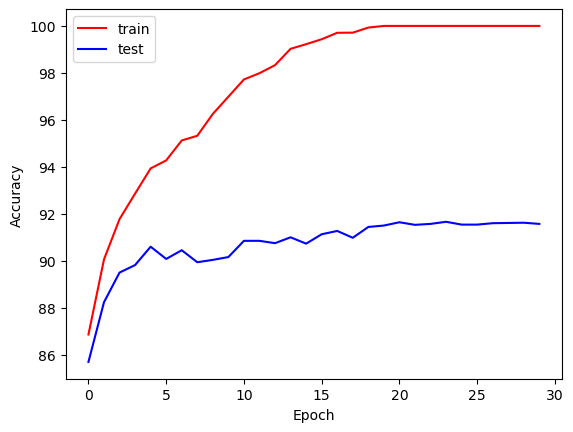

In [16]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()
      
    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.Tanh(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.Tanh(), nn.MaxPool2d(2, stride = 2))
    
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.Tanh(), nn.Linear(1024,256), nn.Tanh(), nn.Linear(256, 10))
 
   
  def forward(self, x):
    
    x = self.cnn_model(x)

    x =x.view(x.size(0), -1)
    
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
device = torch.device("cuda:0")

alpha = 0.1

net = MyCNN().to(device)

net.apply(weights_init)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []
for epoch in range(max_epochs):
  
  loss_epoch = 0
  
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    outputs = net(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


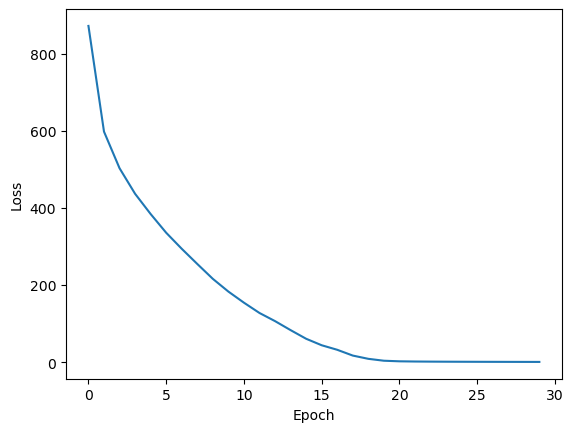

In [17]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

### Using Sigmoid Activation Function

100%|██████████| 1875/1875 [00:09<00:00, 203.00it/s]


Epoch 1: loss: 4338.629977226257, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 203.97it/s]


Epoch 2: loss: 4320.159817457199, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 205.44it/s]


Epoch 3: loss: 4319.2086045742035, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 202.89it/s]


Epoch 4: loss: 4318.101076602936, train accuracy: 17.526666666666667, valid accuracy:17.32


100%|██████████| 1875/1875 [00:09<00:00, 195.82it/s]


Epoch 5: loss: 3422.9856256842613, train accuracy: 61.41166666666667, valid accuracy:60.81


100%|██████████| 1875/1875 [00:09<00:00, 198.16it/s]


Epoch 6: loss: 1577.9660258591175, train accuracy: 71.69833333333334, valid accuracy:70.77


100%|██████████| 1875/1875 [00:09<00:00, 207.17it/s]


Epoch 7: loss: 1301.0205825269222, train accuracy: 72.315, valid accuracy:71.77


100%|██████████| 1875/1875 [00:08<00:00, 209.38it/s]


Epoch 8: loss: 1174.9306388646364, train accuracy: 75.75833333333334, valid accuracy:74.61


100%|██████████| 1875/1875 [00:09<00:00, 203.83it/s]


Epoch 9: loss: 1077.4489442110062, train accuracy: 79.89166666666667, valid accuracy:78.76


100%|██████████| 1875/1875 [00:09<00:00, 206.96it/s]


Epoch 10: loss: 991.9581004232168, train accuracy: 81.575, valid accuracy:80.17


100%|██████████| 1875/1875 [00:09<00:00, 203.91it/s]


Epoch 11: loss: 923.8029671758413, train accuracy: 81.91, valid accuracy:80.77


100%|██████████| 1875/1875 [00:08<00:00, 208.77it/s]


Epoch 12: loss: 872.3038332313299, train accuracy: 83.02833333333334, valid accuracy:81.49


100%|██████████| 1875/1875 [00:08<00:00, 210.11it/s]


Epoch 13: loss: 825.948489151895, train accuracy: 85.0, valid accuracy:83.95


100%|██████████| 1875/1875 [00:09<00:00, 207.11it/s]


Epoch 14: loss: 786.7327634841204, train accuracy: 85.65666666666667, valid accuracy:84.5


100%|██████████| 1875/1875 [00:09<00:00, 206.45it/s]


Epoch 15: loss: 750.800844848156, train accuracy: 86.51166666666667, valid accuracy:85.5


100%|██████████| 1875/1875 [00:09<00:00, 206.84it/s]


Epoch 16: loss: 718.9509493410587, train accuracy: 86.235, valid accuracy:85.15


100%|██████████| 1875/1875 [00:09<00:00, 203.10it/s]


Epoch 17: loss: 696.0804545208812, train accuracy: 86.085, valid accuracy:85.03


100%|██████████| 1875/1875 [00:09<00:00, 196.44it/s]


Epoch 18: loss: 670.4115201756358, train accuracy: 87.76666666666667, valid accuracy:86.54


100%|██████████| 1875/1875 [00:09<00:00, 207.56it/s]


Epoch 19: loss: 652.7044222205877, train accuracy: 87.89666666666666, valid accuracy:86.6


100%|██████████| 1875/1875 [00:08<00:00, 214.09it/s]


Epoch 20: loss: 635.8420058600605, train accuracy: 88.385, valid accuracy:86.92


100%|██████████| 1875/1875 [00:08<00:00, 216.14it/s]


Epoch 21: loss: 620.9208860956132, train accuracy: 87.79833333333333, valid accuracy:86.47


100%|██████████| 1875/1875 [00:08<00:00, 217.32it/s]


Epoch 22: loss: 604.1334788240492, train accuracy: 88.56666666666666, valid accuracy:87.1


100%|██████████| 1875/1875 [00:08<00:00, 221.41it/s]


Epoch 23: loss: 592.4056952632964, train accuracy: 88.88666666666667, valid accuracy:87.44


100%|██████████| 1875/1875 [00:08<00:00, 218.16it/s]


Epoch 24: loss: 579.4697364903986, train accuracy: 89.12666666666667, valid accuracy:87.58


100%|██████████| 1875/1875 [00:08<00:00, 223.79it/s]


Epoch 25: loss: 568.2123823985457, train accuracy: 88.895, valid accuracy:87.66


100%|██████████| 1875/1875 [00:08<00:00, 217.91it/s]


Epoch 26: loss: 559.1085016690195, train accuracy: 89.48833333333333, valid accuracy:87.98


100%|██████████| 1875/1875 [00:08<00:00, 213.40it/s]


Epoch 27: loss: 547.3044192865491, train accuracy: 89.68666666666667, valid accuracy:88.07


100%|██████████| 1875/1875 [00:08<00:00, 217.93it/s]


Epoch 28: loss: 537.4989830609411, train accuracy: 89.9, valid accuracy:88.29


100%|██████████| 1875/1875 [00:08<00:00, 221.73it/s]


Epoch 29: loss: 529.656470309943, train accuracy: 89.33666666666667, valid accuracy:87.73


100%|██████████| 1875/1875 [00:08<00:00, 220.61it/s]


Epoch 30: loss: 522.7023586072028, train accuracy: 90.15, valid accuracy:88.72


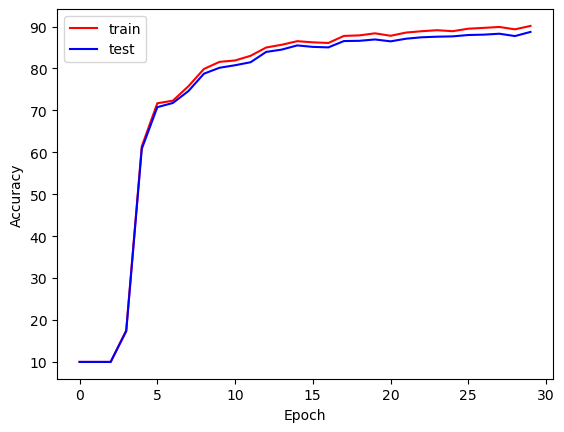

In [18]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.Sigmoid(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.Sigmoid(), nn.MaxPool2d(2, stride = 2))

    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.Sigmoid(), nn.Linear(1024,256), nn.Sigmoid(), nn.Linear(256, 10))
 
   
  def forward(self, x):

    x = self.cnn_model(x)

    x =x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0

  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)

    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
device = torch.device("cuda:0")

alpha = 0.1

net = MyCNN().to(device)

net.apply(weights_init)


loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []

for epoch in range(max_epochs):
  
  loss_epoch = 0
  
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    outputs = net(inputs)
    
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    
    opt.step()
    
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


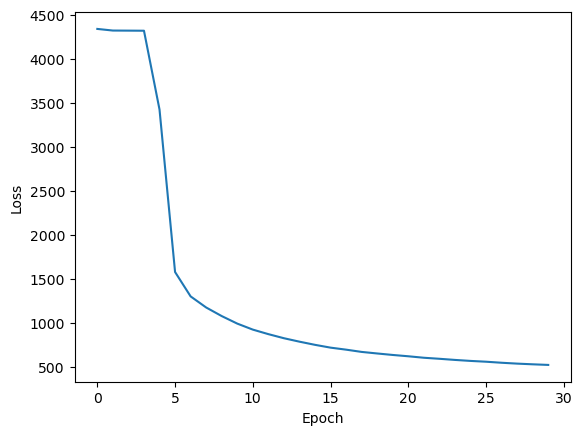

In [19]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

### Using ELU activation function

100%|██████████| 1875/1875 [00:08<00:00, 219.28it/s]


Epoch 1: loss: 861.5997207984328, train accuracy: 86.96333333333334, valid accuracy:86.08


100%|██████████| 1875/1875 [00:08<00:00, 217.12it/s]


Epoch 2: loss: 592.805760871619, train accuracy: 90.48166666666667, valid accuracy:88.69


100%|██████████| 1875/1875 [00:08<00:00, 216.04it/s]


Epoch 3: loss: 507.92263110447675, train accuracy: 91.135, valid accuracy:88.79


100%|██████████| 1875/1875 [00:08<00:00, 210.03it/s]


Epoch 4: loss: 447.13199480064213, train accuracy: 92.955, valid accuracy:90.3


100%|██████████| 1875/1875 [00:08<00:00, 213.53it/s]


Epoch 5: loss: 397.3939229911193, train accuracy: 93.205, valid accuracy:89.65


100%|██████████| 1875/1875 [00:08<00:00, 223.36it/s]


Epoch 6: loss: 356.6821205932647, train accuracy: 93.30333333333333, valid accuracy:90.23


100%|██████████| 1875/1875 [00:08<00:00, 214.10it/s]


Epoch 7: loss: 319.7241372419521, train accuracy: 94.68333333333334, valid accuracy:90.47


100%|██████████| 1875/1875 [00:08<00:00, 224.06it/s]


Epoch 8: loss: 285.94517661072314, train accuracy: 95.76166666666667, valid accuracy:90.89


100%|██████████| 1875/1875 [00:08<00:00, 219.56it/s]


Epoch 9: loss: 259.2492206809111, train accuracy: 96.12833333333333, valid accuracy:90.73


100%|██████████| 1875/1875 [00:08<00:00, 222.30it/s]


Epoch 10: loss: 228.82335701340344, train accuracy: 95.91166666666666, valid accuracy:90.63


100%|██████████| 1875/1875 [00:08<00:00, 217.36it/s]


Epoch 11: loss: 205.0298916316824, train accuracy: 95.895, valid accuracy:90.47


100%|██████████| 1875/1875 [00:08<00:00, 221.81it/s]


Epoch 12: loss: 185.11209721211344, train accuracy: 94.97, valid accuracy:88.65


100%|██████████| 1875/1875 [00:08<00:00, 217.45it/s]


Epoch 13: loss: 174.14963119477034, train accuracy: 95.71833333333333, valid accuracy:89.56


100%|██████████| 1875/1875 [00:08<00:00, 217.38it/s]


Epoch 14: loss: 154.69201945487293, train accuracy: 97.82333333333334, valid accuracy:90.72


100%|██████████| 1875/1875 [00:08<00:00, 221.48it/s]


Epoch 15: loss: 138.62447853430058, train accuracy: 97.895, valid accuracy:90.48


100%|██████████| 1875/1875 [00:08<00:00, 221.48it/s]


Epoch 16: loss: 134.41337820226727, train accuracy: 94.855, valid accuracy:88.31


100%|██████████| 1875/1875 [00:08<00:00, 215.36it/s]


Epoch 17: loss: 144.51377377008612, train accuracy: 97.72666666666667, valid accuracy:90.42


100%|██████████| 1875/1875 [00:08<00:00, 218.33it/s]


Epoch 18: loss: 115.21838653344093, train accuracy: 98.205, valid accuracy:90.34


100%|██████████| 1875/1875 [00:08<00:00, 220.53it/s]


Epoch 19: loss: 95.44914556865115, train accuracy: 98.29, valid accuracy:90.65


100%|██████████| 1875/1875 [00:09<00:00, 202.86it/s]


Epoch 20: loss: 98.10364721107726, train accuracy: 97.945, valid accuracy:90.31


100%|██████████| 1875/1875 [00:08<00:00, 211.98it/s]


Epoch 21: loss: 105.3949284476148, train accuracy: 98.74166666666666, valid accuracy:91.13


100%|██████████| 1875/1875 [00:08<00:00, 219.81it/s]


Epoch 22: loss: 106.28969522375337, train accuracy: 98.92666666666666, valid accuracy:90.86


100%|██████████| 1875/1875 [00:08<00:00, 218.55it/s]


Epoch 23: loss: 99.02392627814243, train accuracy: 97.86333333333333, valid accuracy:90.21


100%|██████████| 1875/1875 [00:09<00:00, 203.57it/s]


Epoch 24: loss: 98.54610830051206, train accuracy: 98.82666666666667, valid accuracy:90.78


100%|██████████| 1875/1875 [00:08<00:00, 215.62it/s]


Epoch 25: loss: 90.74040082228976, train accuracy: 98.68666666666667, valid accuracy:90.29


100%|██████████| 1875/1875 [00:08<00:00, 212.15it/s]


Epoch 26: loss: 85.44690199761453, train accuracy: 98.53, valid accuracy:90.26


100%|██████████| 1875/1875 [00:08<00:00, 215.74it/s]


Epoch 27: loss: 70.28960583376289, train accuracy: 99.25666666666666, valid accuracy:90.73


100%|██████████| 1875/1875 [00:08<00:00, 215.56it/s]


Epoch 28: loss: 59.84788088859477, train accuracy: 98.95, valid accuracy:90.71


100%|██████████| 1875/1875 [00:08<00:00, 219.24it/s]


Epoch 29: loss: 86.33592775917651, train accuracy: 98.995, valid accuracy:90.77


100%|██████████| 1875/1875 [00:08<00:00, 220.04it/s]


Epoch 30: loss: 89.88001223050415, train accuracy: 98.08666666666667, valid accuracy:89.75


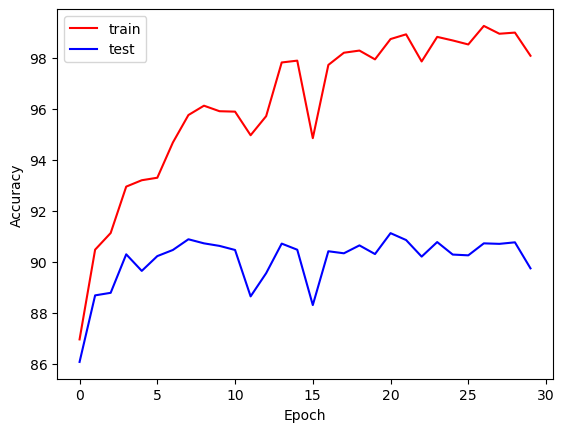

In [20]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.ELU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.ELU(), nn.MaxPool2d(2, stride = 2))
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.ELU(), nn.Linear(1024,256), nn.ELU(), nn.Linear(256, 10))
 
   
  def forward(self, x):
    x = self.cnn_model(x)
    x =x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
device = torch.device("cuda:0")

alpha = 0.1

net = MyCNN().to(device)
net.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)


opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []

for epoch in range(max_epochs):
  
  loss_epoch = 0
 
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    outputs = net(inputs)
    
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    
    opt.step()
    
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


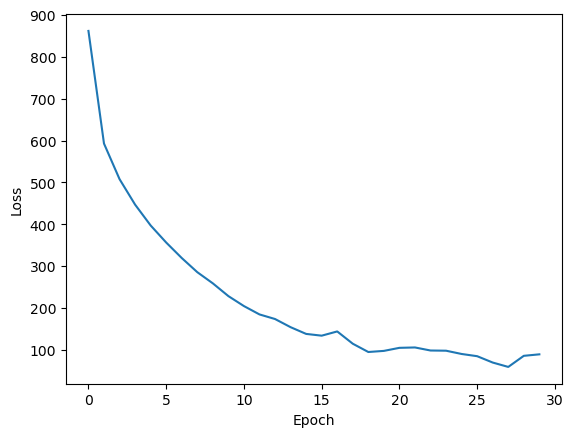

In [21]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

### Keeping Relu and changing learning rates
### Alpha 0.001

100%|██████████| 1875/1875 [00:11<00:00, 165.60it/s]


Epoch 1: loss: 3618.7625079751015, train accuracy: 64.36333333333333, valid accuracy:63.84


100%|██████████| 1875/1875 [00:09<00:00, 204.61it/s]


Epoch 2: loss: 1625.5865469872952, train accuracy: 71.77333333333333, valid accuracy:70.98


100%|██████████| 1875/1875 [00:09<00:00, 207.65it/s]


Epoch 3: loss: 1368.8118923008442, train accuracy: 73.72, valid accuracy:73.12


100%|██████████| 1875/1875 [00:09<00:00, 203.01it/s]


Epoch 4: loss: 1264.5451478362083, train accuracy: 76.09, valid accuracy:74.84


100%|██████████| 1875/1875 [00:09<00:00, 207.65it/s]


Epoch 5: loss: 1194.796497270465, train accuracy: 77.55, valid accuracy:76.71


100%|██████████| 1875/1875 [00:09<00:00, 207.33it/s]


Epoch 6: loss: 1138.9642557650805, train accuracy: 77.77333333333333, valid accuracy:76.16


100%|██████████| 1875/1875 [00:08<00:00, 208.65it/s]


Epoch 7: loss: 1093.2708749771118, train accuracy: 77.66166666666666, valid accuracy:76.52


100%|██████████| 1875/1875 [00:08<00:00, 210.89it/s]


Epoch 8: loss: 1051.0584938079119, train accuracy: 80.03166666666667, valid accuracy:78.56


100%|██████████| 1875/1875 [00:09<00:00, 204.58it/s]


Epoch 9: loss: 1014.5397665798664, train accuracy: 81.05333333333333, valid accuracy:80.08


100%|██████████| 1875/1875 [00:09<00:00, 204.94it/s]


Epoch 10: loss: 983.0633935928345, train accuracy: 80.69, valid accuracy:79.82


100%|██████████| 1875/1875 [00:09<00:00, 200.76it/s]


Epoch 11: loss: 955.2759029865265, train accuracy: 81.84, valid accuracy:80.78


100%|██████████| 1875/1875 [00:09<00:00, 197.96it/s]


Epoch 12: loss: 927.8320671319962, train accuracy: 82.11666666666666, valid accuracy:80.91


100%|██████████| 1875/1875 [00:09<00:00, 207.83it/s]


Epoch 13: loss: 904.0755752772093, train accuracy: 83.37, valid accuracy:82.25


100%|██████████| 1875/1875 [00:08<00:00, 209.69it/s]


Epoch 14: loss: 883.5577346980572, train accuracy: 82.69, valid accuracy:81.32


100%|██████████| 1875/1875 [00:09<00:00, 206.82it/s]


Epoch 15: loss: 863.9517245590687, train accuracy: 84.09833333333333, valid accuracy:82.76


100%|██████████| 1875/1875 [00:09<00:00, 201.36it/s]


Epoch 16: loss: 844.9670797884464, train accuracy: 84.65333333333334, valid accuracy:83.48


100%|██████████| 1875/1875 [00:09<00:00, 199.82it/s]


Epoch 17: loss: 827.492190785706, train accuracy: 84.635, valid accuracy:83.45


100%|██████████| 1875/1875 [00:09<00:00, 202.78it/s]


Epoch 18: loss: 809.3369149267673, train accuracy: 83.775, valid accuracy:82.9


100%|██████████| 1875/1875 [00:09<00:00, 198.93it/s]


Epoch 19: loss: 797.0798190832138, train accuracy: 85.275, valid accuracy:84.17


100%|██████████| 1875/1875 [00:09<00:00, 201.81it/s]


Epoch 20: loss: 780.6656515076756, train accuracy: 85.75833333333334, valid accuracy:84.57


100%|██████████| 1875/1875 [00:09<00:00, 201.73it/s]


Epoch 21: loss: 767.9039840623736, train accuracy: 85.93833333333333, valid accuracy:84.89


100%|██████████| 1875/1875 [00:09<00:00, 204.03it/s]


Epoch 22: loss: 754.2774908691645, train accuracy: 85.735, valid accuracy:84.51


100%|██████████| 1875/1875 [00:09<00:00, 207.61it/s]


Epoch 23: loss: 742.4782672673464, train accuracy: 85.85166666666667, valid accuracy:84.81


100%|██████████| 1875/1875 [00:09<00:00, 204.67it/s]


Epoch 24: loss: 731.3893506526947, train accuracy: 86.66833333333334, valid accuracy:85.2


100%|██████████| 1875/1875 [00:09<00:00, 208.09it/s]


Epoch 25: loss: 721.6437464430928, train accuracy: 86.995, valid accuracy:85.8


100%|██████████| 1875/1875 [00:09<00:00, 206.63it/s]


Epoch 26: loss: 710.9612256884575, train accuracy: 86.71833333333333, valid accuracy:85.47


100%|██████████| 1875/1875 [00:09<00:00, 207.66it/s]


Epoch 27: loss: 700.5411175563931, train accuracy: 86.51333333333334, valid accuracy:85.1


100%|██████████| 1875/1875 [00:09<00:00, 206.12it/s]


Epoch 28: loss: 691.4182823002338, train accuracy: 85.875, valid accuracy:84.69


100%|██████████| 1875/1875 [00:08<00:00, 210.56it/s]


Epoch 29: loss: 682.8402793183923, train accuracy: 86.37166666666667, valid accuracy:84.88


100%|██████████| 1875/1875 [00:09<00:00, 205.88it/s]


Epoch 30: loss: 674.9383529052138, train accuracy: 87.64666666666666, valid accuracy:86.65


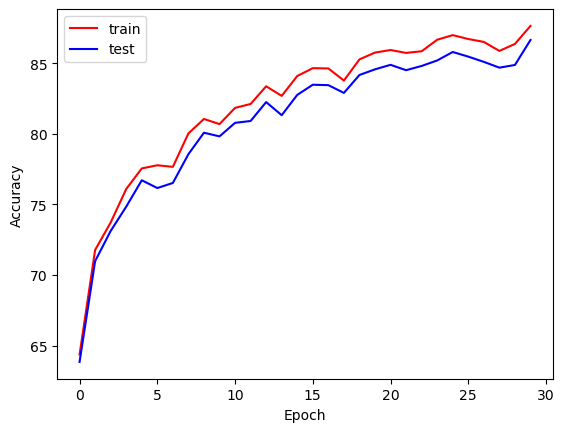

In [6]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.ReLU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.ReLU(), nn.MaxPool2d(2, stride = 2))
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024,256), nn.ReLU(), nn.Linear(256, 10))
 
   
  def forward(self, x):
    x = self.cnn_model(x)
    x =x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
device = torch.device("cuda:0")

alpha = 0.001

net = MyCNN().to(device)
net.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)


opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []

for epoch in range(max_epochs):
  
  loss_epoch = 0
  
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
   
    opt.zero_grad()
    outputs = net(inputs)
    
    loss = loss_fn(outputs, labels)
    
    loss.backward()

    opt.step()
    
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


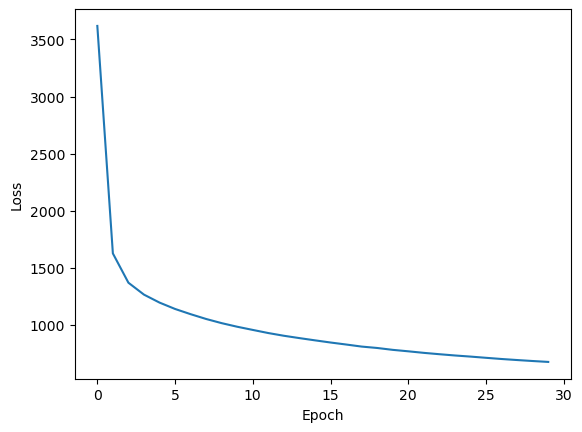

In [6]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

### Alpha 0.1

100%|██████████| 1875/1875 [00:09<00:00, 205.67it/s]


Epoch 1: loss: 1007.7773669958115, train accuracy: 87.395, valid accuracy:86.5


100%|██████████| 1875/1875 [00:09<00:00, 202.15it/s]


Epoch 2: loss: 618.6795137301087, train accuracy: 89.09333333333333, valid accuracy:87.8


100%|██████████| 1875/1875 [00:09<00:00, 206.71it/s]


Epoch 3: loss: 525.0203105658293, train accuracy: 89.96666666666667, valid accuracy:88.16


100%|██████████| 1875/1875 [00:08<00:00, 210.65it/s]


Epoch 4: loss: 467.42307693324983, train accuracy: 91.94333333333333, valid accuracy:89.74


100%|██████████| 1875/1875 [00:08<00:00, 210.68it/s]


Epoch 5: loss: 421.17080923262984, train accuracy: 92.49666666666667, valid accuracy:89.87


100%|██████████| 1875/1875 [00:08<00:00, 212.64it/s]


Epoch 6: loss: 385.1089514438063, train accuracy: 93.65833333333333, valid accuracy:90.82


100%|██████████| 1875/1875 [00:08<00:00, 209.49it/s]


Epoch 7: loss: 346.8623000080697, train accuracy: 93.88333333333334, valid accuracy:90.36


100%|██████████| 1875/1875 [00:08<00:00, 213.40it/s]


Epoch 8: loss: 313.4465536158532, train accuracy: 94.465, valid accuracy:90.6


100%|██████████| 1875/1875 [00:08<00:00, 210.60it/s]


Epoch 9: loss: 283.3843881590292, train accuracy: 95.01166666666667, valid accuracy:90.41


100%|██████████| 1875/1875 [00:08<00:00, 211.61it/s]


Epoch 10: loss: 255.1332191277761, train accuracy: 96.03, valid accuracy:90.92


100%|██████████| 1875/1875 [00:08<00:00, 210.53it/s]


Epoch 11: loss: 231.0895128333941, train accuracy: 96.27, valid accuracy:90.98


100%|██████████| 1875/1875 [00:08<00:00, 213.60it/s]


Epoch 12: loss: 210.26857284433208, train accuracy: 96.38333333333334, valid accuracy:90.87


100%|██████████| 1875/1875 [00:09<00:00, 205.03it/s]


Epoch 13: loss: 181.5737857320346, train accuracy: 97.45666666666666, valid accuracy:91.28


100%|██████████| 1875/1875 [00:08<00:00, 211.11it/s]


Epoch 14: loss: 161.7903630810324, train accuracy: 97.175, valid accuracy:90.79


100%|██████████| 1875/1875 [00:08<00:00, 208.56it/s]


Epoch 15: loss: 155.48488158232067, train accuracy: 96.7, valid accuracy:90.18


100%|██████████| 1875/1875 [00:08<00:00, 210.15it/s]


Epoch 16: loss: 142.73610039107734, train accuracy: 97.74333333333334, valid accuracy:91.09


100%|██████████| 1875/1875 [00:08<00:00, 211.46it/s]


Epoch 17: loss: 125.57003640670155, train accuracy: 98.19, valid accuracy:90.9


100%|██████████| 1875/1875 [00:09<00:00, 208.19it/s]


Epoch 18: loss: 112.11161753023043, train accuracy: 98.295, valid accuracy:90.74


100%|██████████| 1875/1875 [00:09<00:00, 205.66it/s]


Epoch 19: loss: 116.46319820603821, train accuracy: 98.09166666666667, valid accuracy:91.19


100%|██████████| 1875/1875 [00:09<00:00, 206.66it/s]


Epoch 20: loss: 101.4108241571812, train accuracy: 97.84666666666666, valid accuracy:90.77


100%|██████████| 1875/1875 [00:09<00:00, 208.33it/s]


Epoch 21: loss: 99.197858064319, train accuracy: 98.51, valid accuracy:90.92


100%|██████████| 1875/1875 [00:09<00:00, 204.86it/s]


Epoch 22: loss: 94.67617718080874, train accuracy: 98.23166666666667, valid accuracy:90.55


100%|██████████| 1875/1875 [00:09<00:00, 207.79it/s]


Epoch 23: loss: 82.54937078527291, train accuracy: 98.11333333333333, valid accuracy:90.29


100%|██████████| 1875/1875 [00:08<00:00, 209.28it/s]


Epoch 24: loss: 71.85062555948537, train accuracy: 98.78833333333333, valid accuracy:90.85


100%|██████████| 1875/1875 [00:08<00:00, 209.19it/s]


Epoch 25: loss: 60.207135667873445, train accuracy: 99.23, valid accuracy:91.43


100%|██████████| 1875/1875 [00:08<00:00, 210.12it/s]


Epoch 26: loss: 64.36050524171878, train accuracy: 99.34166666666667, valid accuracy:91.18


100%|██████████| 1875/1875 [00:09<00:00, 206.96it/s]


Epoch 27: loss: 61.19558649375358, train accuracy: 99.11666666666666, valid accuracy:90.66


100%|██████████| 1875/1875 [00:09<00:00, 207.28it/s]


Epoch 28: loss: 53.91524251549163, train accuracy: 99.22333333333333, valid accuracy:91.17


100%|██████████| 1875/1875 [00:09<00:00, 206.13it/s]


Epoch 29: loss: 42.08377413471658, train accuracy: 99.52833333333334, valid accuracy:91.2


100%|██████████| 1875/1875 [00:09<00:00, 207.19it/s]


Epoch 30: loss: 48.886392472760235, train accuracy: 99.09333333333333, valid accuracy:90.93


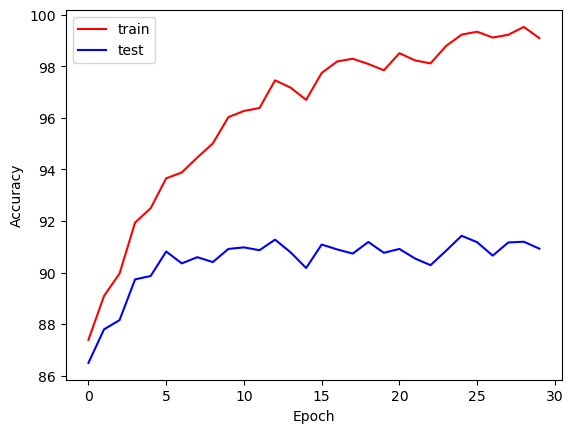

In [14]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.ReLU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.ReLU(), nn.MaxPool2d(2, stride = 2))
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024,256), nn.ReLU(), nn.Linear(256, 10))
 
   
  def forward(self, x):
    x = self.cnn_model(x)
    x =x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
device = torch.device("cuda:0")

alpha = 0.1

net = MyCNN().to(device)
net.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)


opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []

for epoch in range(max_epochs):
  
  loss_epoch = 0
  
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    outputs = net(inputs)
    
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    
    opt.step()
    
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


### Alpha 0.5

In [15]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.ReLU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.ReLU(), nn.MaxPool2d(2, stride = 2))
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024,256), nn.ReLU(), nn.Linear(256, 10))
 
   
  def forward(self, x):
    x = self.cnn_model(x)
    x =x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)


100%|██████████| 1875/1875 [00:09<00:00, 202.37it/s]


Epoch 1: loss: 4327.25992667675, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 204.62it/s]


Epoch 2: loss: 4324.134275436401, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 208.05it/s]


Epoch 3: loss: 4324.325354337692, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 204.46it/s]


Epoch 4: loss: 4324.205881118774, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 208.61it/s]


Epoch 5: loss: 4324.374022245407, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 203.56it/s]


Epoch 6: loss: 4324.437336921692, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 205.01it/s]


Epoch 7: loss: 4324.227868080139, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 206.64it/s]


Epoch 8: loss: 4323.8999099731445, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 208.58it/s]


Epoch 9: loss: 4324.346138715744, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 208.08it/s]


Epoch 10: loss: 4324.326446771622, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 206.26it/s]


Epoch 11: loss: 4324.4994597435, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 211.54it/s]


Epoch 12: loss: 4324.576979637146, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 218.66it/s]


Epoch 13: loss: 4323.885257959366, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 213.29it/s]


Epoch 14: loss: 4324.636081695557, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 211.72it/s]


Epoch 15: loss: 4324.765920639038, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 212.44it/s]


Epoch 16: loss: 4323.952121019363, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 213.58it/s]


Epoch 17: loss: 4324.43915605545, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 214.32it/s]


Epoch 18: loss: 4324.362956285477, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 213.40it/s]


Epoch 19: loss: 4324.302263975143, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 213.95it/s]


Epoch 20: loss: 4324.231812477112, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 212.72it/s]


Epoch 21: loss: 4324.193344593048, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 210.16it/s]


Epoch 22: loss: 4324.629523992538, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 218.33it/s]


Epoch 23: loss: 4324.132972478867, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 213.46it/s]


Epoch 24: loss: 4324.310794830322, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 211.05it/s]


Epoch 25: loss: 4324.19606757164, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 210.66it/s]


Epoch 26: loss: 4324.266227960587, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 212.55it/s]


Epoch 27: loss: 4324.708225727081, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 211.41it/s]


Epoch 28: loss: 4323.9952845573425, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 213.21it/s]


Epoch 29: loss: 4324.679215669632, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 214.04it/s]


Epoch 30: loss: 4324.057768344879, train accuracy: 10.0, valid accuracy:10.0


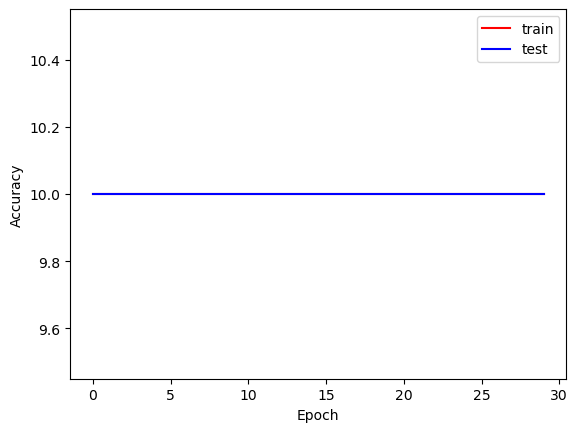

In [16]:
device = torch.device("cuda:0")

alpha = 0.5

net = MyCNN().to(device)
net.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)


opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []

for epoch in range(max_epochs):
  
  loss_epoch = 0
  
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    outputs = net(inputs)
    
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    
    opt.step()
    
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


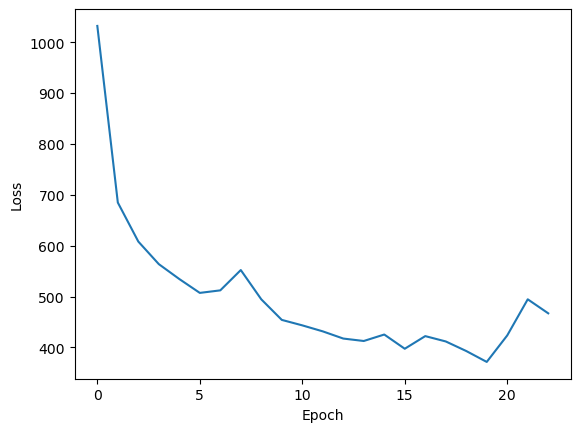

In [13]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

### Alpha 1

100%|██████████| 1875/1875 [00:08<00:00, 209.17it/s]


Epoch 1: loss: 4343.479623556137, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 229.02it/s]


Epoch 2: loss: 4331.84784412384, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 229.84it/s]


Epoch 3: loss: 4330.8550391197205, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 230.45it/s]


Epoch 4: loss: 4331.426601886749, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 232.84it/s]


Epoch 5: loss: 4330.903665065765, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 231.44it/s]


Epoch 6: loss: 4330.565727233887, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 230.41it/s]


Epoch 7: loss: 4330.468054294586, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 224.89it/s]


Epoch 8: loss: 4331.359219312668, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 228.94it/s]


Epoch 9: loss: 4332.233021736145, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 231.00it/s]


Epoch 10: loss: 4330.7135899066925, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 228.32it/s]


Epoch 11: loss: 4331.290590763092, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 225.65it/s]


Epoch 12: loss: 4331.961846828461, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 228.61it/s]


Epoch 13: loss: 4330.546881437302, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 230.04it/s]


Epoch 14: loss: 4331.163269996643, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 230.41it/s]


Epoch 15: loss: 4332.354648351669, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 229.86it/s]


Epoch 16: loss: 4331.323058128357, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 230.05it/s]


Epoch 17: loss: 4331.050208330154, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 231.06it/s]


Epoch 18: loss: 4332.028497457504, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 225.35it/s]


Epoch 19: loss: 4330.407162189484, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 215.76it/s]


Epoch 20: loss: 4331.366294622421, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 228.44it/s]


Epoch 21: loss: 4331.435862541199, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 230.93it/s]


Epoch 22: loss: 4331.82289981842, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 231.82it/s]


Epoch 23: loss: 4331.805905580521, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 225.70it/s]


Epoch 24: loss: 4330.358745098114, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 229.02it/s]


Epoch 25: loss: 4331.271201372147, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 226.95it/s]


Epoch 26: loss: 4331.090270519257, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 230.72it/s]


Epoch 27: loss: 4331.2760643959045, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 224.75it/s]


Epoch 28: loss: 4332.572809934616, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 209.64it/s]


Epoch 29: loss: 4330.848351716995, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 227.98it/s]


Epoch 30: loss: 4331.283702373505, train accuracy: 10.0, valid accuracy:10.0


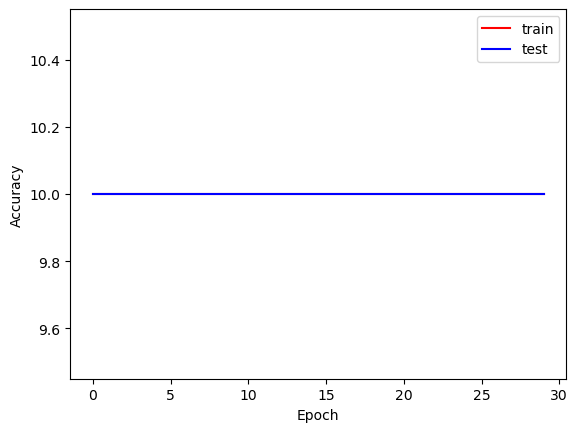

In [9]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.ReLU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.ReLU(), nn.MaxPool2d(2, stride = 2))
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024,256), nn.ReLU(), nn.Linear(256, 10))
 
   
  def forward(self, x):
    x = self.cnn_model(x)
    x =x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
device = torch.device("cuda:0")

alpha = 1

net = MyCNN().to(device)
net.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)


opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []

for epoch in range(max_epochs):
  
  loss_epoch = 0
  
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    outputs = net(inputs)
    
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    
    opt.step()
    
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


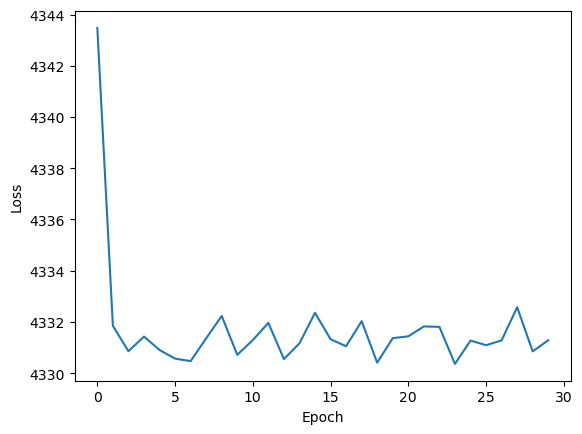

In [10]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

### Alpha 10

100%|██████████| 1875/1875 [00:08<00:00, 227.92it/s]


Epoch 1: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 218.12it/s]


Epoch 2: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 232.86it/s]


Epoch 3: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 229.89it/s]


Epoch 4: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 229.36it/s]


Epoch 5: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 232.29it/s]


Epoch 6: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:07<00:00, 237.78it/s]


Epoch 7: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 234.10it/s]


Epoch 8: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:09<00:00, 205.54it/s]


Epoch 9: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 209.07it/s]


Epoch 10: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:07<00:00, 235.41it/s]


Epoch 11: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 232.35it/s]


Epoch 12: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 231.92it/s]


Epoch 13: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 222.36it/s]


Epoch 14: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 222.63it/s]


Epoch 15: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 229.63it/s]


Epoch 16: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:07<00:00, 234.99it/s]


Epoch 17: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 228.51it/s]


Epoch 18: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 232.83it/s]


Epoch 19: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 234.21it/s]


Epoch 20: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 232.61it/s]


Epoch 21: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:07<00:00, 234.50it/s]


Epoch 22: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 234.01it/s]


Epoch 23: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:07<00:00, 234.86it/s]


Epoch 24: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 234.09it/s]


Epoch 25: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 226.81it/s]


Epoch 26: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 229.66it/s]


Epoch 27: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 231.85it/s]


Epoch 28: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:07<00:00, 235.75it/s]


Epoch 29: loss: nan, train accuracy: 10.0, valid accuracy:10.0


100%|██████████| 1875/1875 [00:08<00:00, 232.64it/s]


Epoch 30: loss: nan, train accuracy: 10.0, valid accuracy:10.0


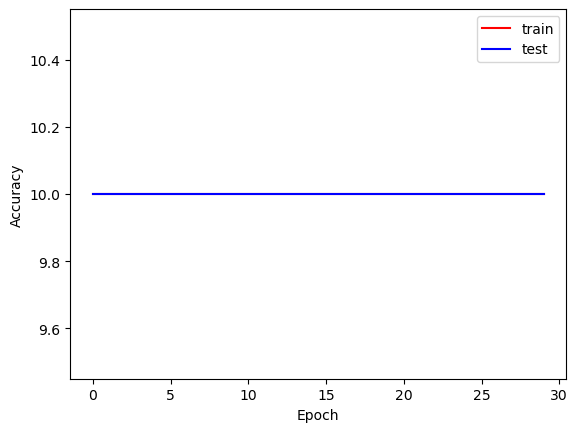

In [11]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.ReLU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.ReLU(), nn.MaxPool2d(2, stride = 2))
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024,256), nn.ReLU(), nn.Linear(256, 10))
 
   
  def forward(self, x):
    x = self.cnn_model(x)
    x =x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
device = torch.device("cuda:0")

alpha = 10

net = MyCNN().to(device)
net.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)


opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []

for epoch in range(max_epochs):
  
  loss_epoch = 0
  
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    outputs = net(inputs)
    
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    
    opt.step()
    
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


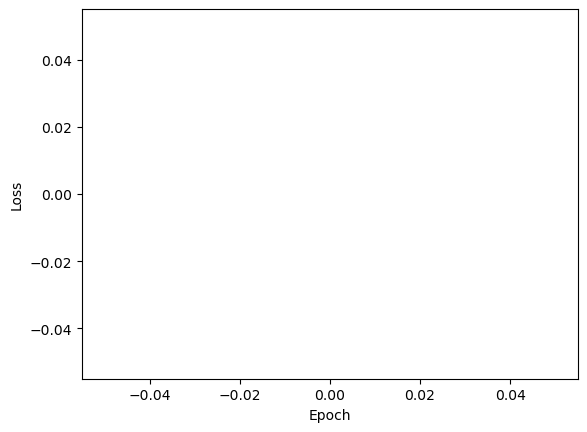

In [12]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)

### Adding  dropout of 0.3 rate on the second fully connected layer (keeping ReLU and learning rate 0.1).

100%|██████████| 1875/1875 [00:08<00:00, 230.96it/s]


Epoch 1: loss: 1027.8882740810513, train accuracy: 87.01666666666667, valid accuracy:86.27


100%|██████████| 1875/1875 [00:08<00:00, 224.78it/s]


Epoch 2: loss: 627.2560871429741, train accuracy: 89.435, valid accuracy:88.15


100%|██████████| 1875/1875 [00:08<00:00, 228.15it/s]


Epoch 3: loss: 533.3277498520911, train accuracy: 90.965, valid accuracy:89.07


100%|██████████| 1875/1875 [00:08<00:00, 229.38it/s]


Epoch 4: loss: 478.65417223609984, train accuracy: 90.77666666666667, valid accuracy:88.74


100%|██████████| 1875/1875 [00:08<00:00, 218.44it/s]


Epoch 5: loss: 433.21052613668144, train accuracy: 91.83666666666667, valid accuracy:89.56


100%|██████████| 1875/1875 [00:08<00:00, 224.41it/s]


Epoch 6: loss: 399.0755520351231, train accuracy: 93.085, valid accuracy:89.95


100%|██████████| 1875/1875 [00:08<00:00, 228.92it/s]


Epoch 7: loss: 361.6312027350068, train accuracy: 93.79666666666667, valid accuracy:90.69


100%|██████████| 1875/1875 [00:08<00:00, 227.34it/s]


Epoch 8: loss: 334.2355803058017, train accuracy: 93.70833333333333, valid accuracy:90.01


100%|██████████| 1875/1875 [00:08<00:00, 227.41it/s]


Epoch 9: loss: 301.5720901209861, train accuracy: 94.90166666666667, valid accuracy:90.53


100%|██████████| 1875/1875 [00:08<00:00, 226.32it/s]


Epoch 10: loss: 276.81374877039343, train accuracy: 95.20333333333333, valid accuracy:90.57


100%|██████████| 1875/1875 [00:08<00:00, 221.59it/s]


Epoch 11: loss: 253.72209938243032, train accuracy: 94.99666666666667, valid accuracy:89.84


100%|██████████| 1875/1875 [00:08<00:00, 230.08it/s]


Epoch 12: loss: 230.62796638463624, train accuracy: 95.76166666666667, valid accuracy:90.59


100%|██████████| 1875/1875 [00:08<00:00, 227.56it/s]


Epoch 13: loss: 211.95444810995832, train accuracy: 96.39166666666667, valid accuracy:90.98


100%|██████████| 1875/1875 [00:08<00:00, 226.26it/s]


Epoch 14: loss: 194.29583363444544, train accuracy: 96.89166666666667, valid accuracy:90.9


100%|██████████| 1875/1875 [00:08<00:00, 224.12it/s]


Epoch 15: loss: 170.42090343881864, train accuracy: 97.49833333333333, valid accuracy:91.04


100%|██████████| 1875/1875 [00:08<00:00, 216.67it/s]


Epoch 16: loss: 169.4480820397148, train accuracy: 97.46833333333333, valid accuracy:91.02


100%|██████████| 1875/1875 [00:08<00:00, 215.98it/s]


Epoch 17: loss: 154.15659883327316, train accuracy: 97.46, valid accuracy:90.89


100%|██████████| 1875/1875 [00:08<00:00, 225.36it/s]


Epoch 18: loss: 137.8260030882957, train accuracy: 98.08666666666667, valid accuracy:91.65


100%|██████████| 1875/1875 [00:08<00:00, 224.42it/s]


Epoch 19: loss: 126.293671007792, train accuracy: 97.87666666666667, valid accuracy:90.66


100%|██████████| 1875/1875 [00:08<00:00, 226.27it/s]


Epoch 20: loss: 129.5542356929509, train accuracy: 98.11833333333334, valid accuracy:91.14


100%|██████████| 1875/1875 [00:08<00:00, 226.53it/s]


Epoch 21: loss: 115.71482856353396, train accuracy: 98.13333333333334, valid accuracy:90.82


100%|██████████| 1875/1875 [00:08<00:00, 223.66it/s]


Epoch 22: loss: 104.38161296614271, train accuracy: 98.41833333333334, valid accuracy:91.03


100%|██████████| 1875/1875 [00:08<00:00, 224.17it/s]


Epoch 23: loss: 98.15635951187141, train accuracy: 98.745, valid accuracy:91.27


100%|██████████| 1875/1875 [00:08<00:00, 224.06it/s]


Epoch 24: loss: 92.5329104873017, train accuracy: 98.21833333333333, valid accuracy:90.69


100%|██████████| 1875/1875 [00:08<00:00, 225.83it/s]


Epoch 25: loss: 87.62711514559305, train accuracy: 98.07, valid accuracy:90.6


100%|██████████| 1875/1875 [00:08<00:00, 223.06it/s]


Epoch 26: loss: 85.43572066098932, train accuracy: 99.055, valid accuracy:90.87


100%|██████████| 1875/1875 [00:08<00:00, 222.16it/s]


Epoch 27: loss: 75.45687525130779, train accuracy: 98.635, valid accuracy:90.57


100%|██████████| 1875/1875 [00:08<00:00, 228.80it/s]


Epoch 28: loss: 75.45074970596761, train accuracy: 99.05166666666666, valid accuracy:90.96


100%|██████████| 1875/1875 [00:08<00:00, 227.05it/s]


Epoch 29: loss: 78.46397557734667, train accuracy: 99.17666666666666, valid accuracy:91.0


100%|██████████| 1875/1875 [00:08<00:00, 228.16it/s]


Epoch 30: loss: 59.04133151176393, train accuracy: 99.52, valid accuracy:91.06


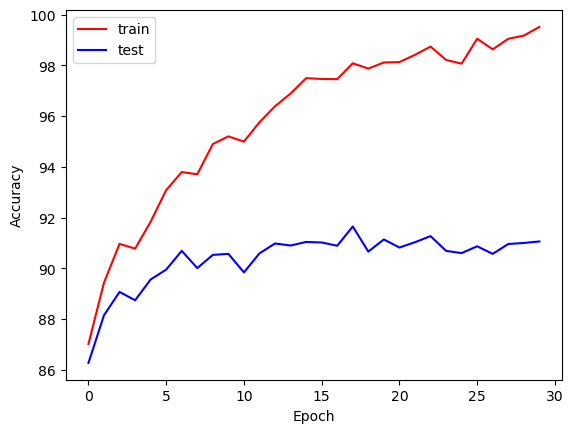

In [13]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.cnn_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 5, stride=1), nn.ReLU(), nn.MaxPool2d(2, stride=2), nn.Conv2d(32, 64, kernel_size = 5, stride = 1), nn.ReLU(), nn.MaxPool2d(2, stride = 2))
    
    # Dropout is applied after the activation function in second fully connected layer
    
    self.fc_model = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Linear(1024,256), nn.ReLU(),nn.Dropout(0.3), nn.Linear(256, 10))
 
   
  def forward(self, x):
    x = self.cnn_model(x)
    x =x.view(x.size(0), -1)
    x = self.fc_model(x)
    
    return x
def evaluation(dataloader):
  total, correct = 0,0
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        
alpha = 0.1

net = MyCNN().to(device)
net.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)


opt = torch.optim.SGD(list(net.parameters()), lr=alpha)
    
loss_epoch_array = []
max_epochs = 30
loss_epoch = 0
train_accuracy = []
test_accuracy = []

for epoch in range(max_epochs):
  
  loss_epoch = 0
  
  for i, data in enumerate(tqdm(train_loader), 0):
    
    net.train()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()
    outputs = net(inputs)
    
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    
    opt.step()
    
    loss_epoch += loss.item()
  
  loss_epoch_array.append(loss_epoch)
  train_accuracy.append(evaluation(train_loader))
  test_accuracy.append(evaluation(test_loader))
  print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], test_accuracy[-1]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, "r")
plt.plot(test_accuracy, "b")
plt.gca().legend(('train','test'))


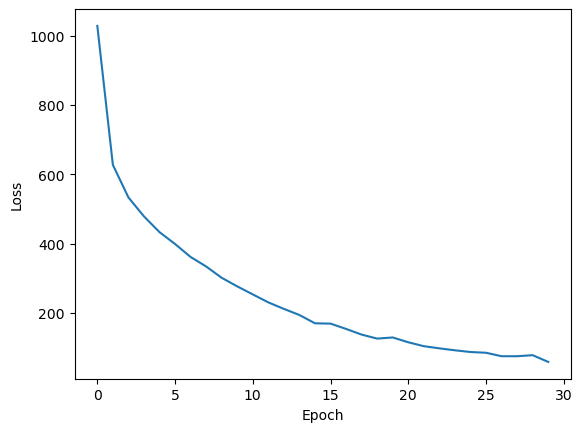

In [14]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch_array)